### Financial News Headline Sentiment Analysis
This notebook explores the Sentiment Analysis of financial news headlines using a well-known dataset from the Financial Phrase Bank. The primary objective of this project is to classify financial news sentences into three sentiment categories: positive, neutral and negative. This analysis leverages a variety of traditional machine learning algorithms, deep learning models, and transformer-based models to determine the effectiveness of different approaches for sentiment classification.

### Dataset Overview
Financial Phrasebank dataset consists of 2,264 sentences taken from English language financial news articles. Each sentence is labeled with one of the three sentiment categories
- Positive (2)
- Neutral (1)
- Negative (0)

Each sentence is tokenized and categorized by multiple annotators to ensure the reliability of the sentiment labels. The dataset offers a strong foundation for experimenting with various machine learning and deep learning techniques for text classification.

### Key Steps in the Analysis
- **Data Preprocessing**: Begins by preparing the dataset for analysis, including tokenization, vectorization (using TF-IDF), and splitting the data into training and test sets.
- **Traditional Machine Learning Models**: Explores multiple machine learning algorithms such as Logistic Regression, Random Forest, Naive Bayes, and SVM. The focus is on comparing performance using TF-IDF and Bag of Words for text vectorization.
- **Deep Learning Models**: Extends the analysis by training LSTM (Long Short-Term Memory) models for sentiment classification, analyzing training accuracy, loss, and overall performance.
- **Transformer-Based Models (BERT)**: Finally, it experiments with transformer-based models, including FinBERT, to see how advanced techniques can improve performance over traditional models.

### Evaluation Metrics
The models are evaluated based on accuracy and F1 score, with additional insights into model loss and convergence rates. The results from the models are compared to highlight the strengths and weaknesses of each approach.

By the end of this notebook, it is seen that FinBERT, a BERT-based model, outperforms traditional models and demonstrates the power of transformer architectures for financial sentiment analysis.

In [1]:
# import necessary libraries

from datasets import load_dataset

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize 
from nltk import pos_tag, ne_chunk
from nltk import FreqDist 
from nltk.text import Text
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures, TrigramCollocationFinder
from nltk.metrics import TrigramAssocMeasures

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split 
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score, \
    roc_auc_score, roc_curve, auc, mean_squared_error, classification_report, RocCurveDisplay 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout

import spacy
# python -m spacy download en_core_web_sm # download using the command
# Load the SpaCy English language model
nlp = spacy.load('en_core_web_sm')

# download nltk resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

2024-03-31 16:54:19.024563: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-31 16:54:19.029736: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-31 16:54:19.098944: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Load Dataset

In [2]:
# load dataset from huggingface datasets library
dataset = load_dataset("financial_phrasebank", "sentences_allagree")
dataset

Generating train split:   0%|          | 0/2264 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2264
    })
})

In [3]:
# load data into pandas dataframe
df = pd.DataFrame(dataset['train'])
df.head()

,sentence,label
0,"According to Gran , the company has no plans t...",1
1,"For the last quarter of 2010 , Componenta 's n...",2
2,"In the third quarter of 2010 , net sales incre...",2
3,Operating profit rose to EUR 13.1 mn from EUR ...,2
4,"Operating profit totalled EUR 21.1 mn , up fro...",2


In [4]:
df.info()
# no null data is found

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2264 entries, 0 to 2263
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  2264 non-null   object
 1   label     2264 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 35.5+ KB


In [5]:
# counts by label categories 
df.label.value_counts()

label
1    1391
2     570
0     303
Name: count, dtype: int64

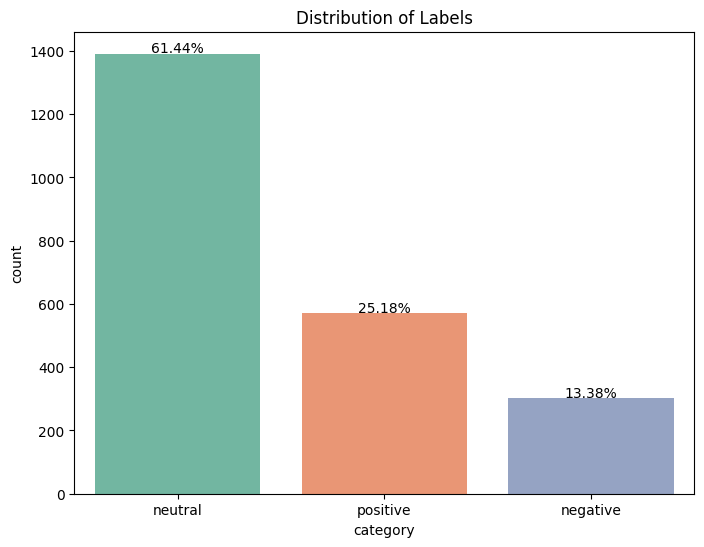

In [6]:
# plot count by label categories
df['category'] = df['label'].apply(lambda x: "negative" if x == 0 else ("neutral" if x == 1 else "positive"))

# Adjust width and height as needed
fig, ax = plt.subplots(1, 1, figsize=(8, 6))  
total_count = df.shape[0]

countplot = sns.countplot(x='category', data=df, palette='Set2')
countplot.set_title('Distribution of Labels')

# Annotate bars with percentages
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total_count), ha='center')
    

plt.show()

There is an imbalance in the dataset with respect to labels / classes, the dataset contains 61% of neutral, 25% of positive and 13% of negative sentences.this can lead of bias in the dataset

# Text Preprocessing

In [7]:
#nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package words to /home/jupyter/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

### Lemmatization and Stemming on the text

Lemmatization and stemming are two common techniques used for word normalization in natural language processing (NLP) tasks. While both methods aim to reduce words to their base or root form, they differ in their approach:

- **Stemming**: Stemming chops off prefixes or suffixes of words to derive their root form. For example, "running" becomes "run", "easily" becomes "easili".
- **Lemmatization**: Lemmatization, on the other hand, transforms words to their dictionary or lemma form, considering the word's context and morphological analysis. For example, "running" becomes "run", "better" becomes "good".

**Why I chose Lemmatization over Stemming?**
Lemmatization provides better accuracy by preserving the semantic meaning of words.It produces more readable and interpretable results, crucial for financial sentiment analysis where nuanced meaning is important. 
While lemmatization might be computationally more expensive compared to stemming, the trade-off is justifiable for improved performance.

More examples of lemma and stem differences in pre-processing can be seen in the dataset.

### Preprocessing Steps

**Lowercasing**: Convert all text to lowercase to ensure uniformity and reduce vocabulary size.

**Removing Special Characters and Punctuations**: Eliminate non-alphabetic characters, such as symbols and numbers, as they don't contribute much to sentiment analysis.

**Tokenization**: Split text into individual words or tokens for further processing.

**Stopword Removal**: Exclude common English stopwords that do not carry significant meaning.

**Lemmatization vs. Stemming**: Apply either lemmatization or stemming to normalize words.

**Excluding non-sentiment-bearing words**: Excluding words like EUR, MN ... as they cause misrepresentation of sentiment and noise in the data hence removing 

In [8]:
# trying both stemming and lemmatization separately to compare performance

stemmer = SnowballStemmer("english")
lm = WordNetLemmatizer()

default_stopwords = set(stopwords.words('english'))
words_to_retain = {'no', 'not'}
words_to_exclude = {'eur', 'mn', 'million', 'mln', 'euro', 'usd', 'biohit', 
                    'oyj', 'hel', 'biobv', 'rautaruukki', 'rtrks', 'cth', 
                    'dollar', 'dollars', 'ilkka', 'yhtyma'}
stop_words = default_stopwords.union(words_to_exclude) - words_to_retain


def stem_preprocess(text_string):
    # Convert everything to lower case, remove special characters and punctuations
    text_string = text_string.lower()
    text_string = re.sub('[^A-Za-z]+', ' ', text_string) 
    
    # Tokenizes, removes single characters and stopwords, and stem the words
    tokens = word_tokenize(text_string)
    stemmed_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words and len(word) > 1]
    
    # join words and remove extra whitespaces before returning
    stemmed_text = ' '.join(stemmed_tokens) 
    return stemmed_text.strip(), stemmed_tokens


def lemma_preprocess(text_string):
    # Convert everything to lower case, remove special characters and punctuations
    text_string = re.sub('[^A-Za-z]+', ' ', text_string) 
    
    # Tokenizes, removes single characters and stopwords, and lemmatize the words
    tokens = word_tokenize(text_string)
    
    # Remove named entities
    cleaned_tokens = []
    for token in tokens:
        doc = nlp(token)
        if not doc.ents:  # Exclude if it's an entity
            cleaned_tokens.append(token)
    
    lower_tokens = [token.lower() for token in cleaned_tokens]
    lemmatized_tokens = [lm.lemmatize(word) for word in lower_tokens if word not in stop_words and len(word) > 1]
        
    # Join words and remove extra whitespaces before returning
    cleaned_text = ' '.join(lemmatized_tokens)
    return cleaned_text.strip(), lemmatized_tokens

In [9]:
df.head()

,sentence,label,category
0,"According to Gran , the company has no plans t...",1,neutral
1,"For the last quarter of 2010 , Componenta 's n...",2,positive
2,"In the third quarter of 2010 , net sales incre...",2,positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,2,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",2,positive


In [10]:
# stemming text and stem tokens
df['stem_text'], df['stem_tokens'] = zip(*df['sentence'].apply(stem_preprocess))
df.head()

,sentence,label,category,stem_text,stem_tokens
0,"According to Gran , the company has no plans t...",1,neutral,accord gran compani no plan move product russi...,"[accord, gran, compani, no, plan, move, produc..."
1,"For the last quarter of 2010 , Componenta 's n...",2,positive,last quarter componenta net sale doubl period ...,"[last, quarter, componenta, net, sale, doubl, ..."
2,"In the third quarter of 2010 , net sales incre...",2,positive,third quarter net sale increas oper profit,"[third, quarter, net, sale, increas, oper, pro..."
3,Operating profit rose to EUR 13.1 mn from EUR ...,2,positive,oper profit rose correspond period repres net ...,"[oper, profit, rose, correspond, period, repre..."
4,"Operating profit totalled EUR 21.1 mn , up fro...",2,positive,oper profit total repres net sale,"[oper, profit, total, repres, net, sale]"


In [11]:
# lemma text and tokens
df['lemma_text'], df['lemma_tokens'] = zip(*df['sentence'].apply(lemma_preprocess))
df.head()

,sentence,label,category,stem_text,stem_tokens,lemma_text,lemma_tokens
0,"According to Gran , the company has no plans t...",1,neutral,accord gran compani no plan move product russi...,"[accord, gran, compani, no, plan, move, produc...",according gran company no plan move production...,"[according, gran, company, no, plan, move, pro..."
1,"For the last quarter of 2010 , Componenta 's n...",2,positive,last quarter componenta net sale doubl period ...,"[last, quarter, componenta, net, sale, doubl, ...",last quarter net sale doubled period year earl...,"[last, quarter, net, sale, doubled, period, ye..."
2,"In the third quarter of 2010 , net sales incre...",2,positive,third quarter net sale increas oper profit,"[third, quarter, net, sale, increas, oper, pro...",quarter net sale increased operating profit,"[quarter, net, sale, increased, operating, pro..."
3,Operating profit rose to EUR 13.1 mn from EUR ...,2,positive,oper profit rose correspond period repres net ...,"[oper, profit, rose, correspond, period, repre...",operating profit rose corresponding period rep...,"[operating, profit, rose, corresponding, perio..."
4,"Operating profit totalled EUR 21.1 mn , up fro...",2,positive,oper profit total repres net sale,"[oper, profit, total, repres, net, sale]",operating profit totalled representing net sale,"[operating, profit, totalled, representing, ne..."


# Text Analysis / EDA

## Word Cloud

In [12]:
# Word Cloud
def generate_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=50,
        scale=5,
        random_state=1,
        max_font_size=100, 
        colormap='viridis',            # Color map for the word cloud
        contour_color='steelblue',     # Contour color
        contour_width=2,               # Contour width
#        collocations=False,            # Whether to consider collocations (bigrams) or not
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10), edgecolor='k')
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=1.4)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

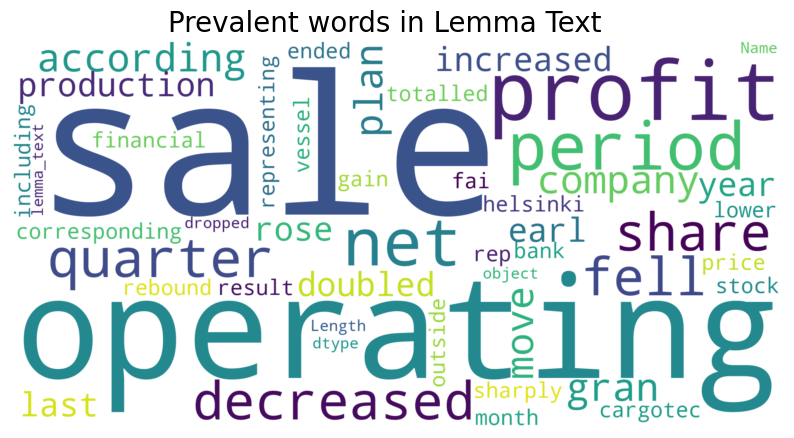

In [13]:
generate_wordcloud(df['lemma_text'], 'Prevalent words in Lemma Text')

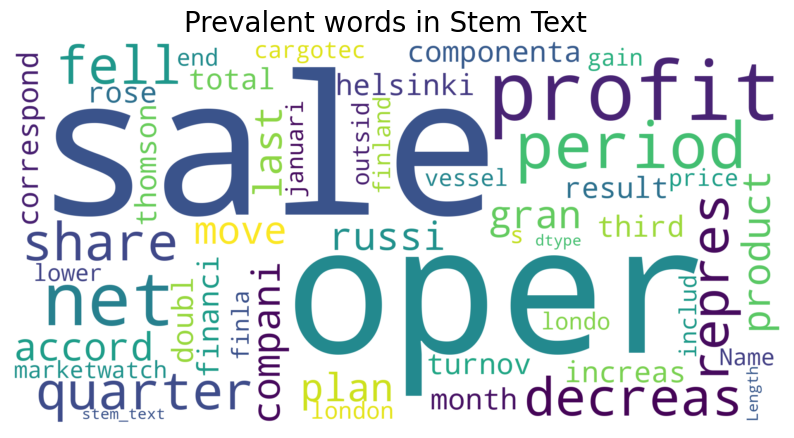

In [14]:
generate_wordcloud(df['stem_text'], 'Prevalent words in Stem Text')

In [15]:
# stem and lemma wordclouds seem to be close expect for some overstemming words in stem

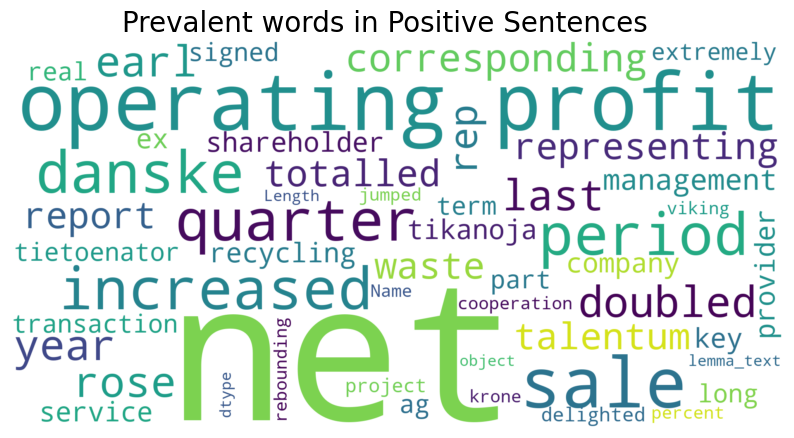

In [16]:
generate_wordcloud(df.loc[df['category'] == 'positive']['lemma_text'], 
                   'Prevalent words in Positive Sentences')

In [17]:
# most prevalent words in positive sentences appear to be profit, operating, 

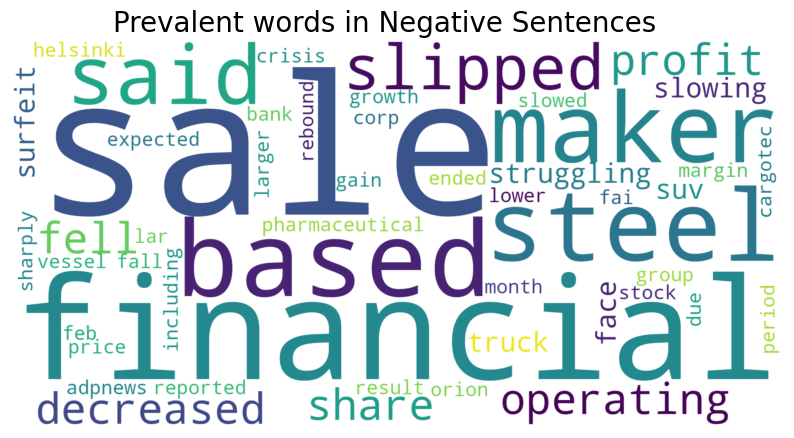

In [18]:
generate_wordcloud(df.loc[df['category'] == 'negative']['lemma_text'], 
                   'Prevalent words in Negative Sentences')

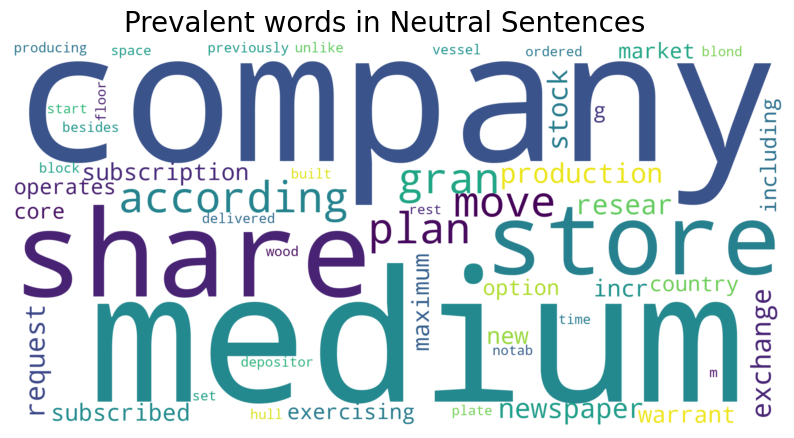

In [19]:
generate_wordcloud(df.loc[df['category'] == 'neutral']['lemma_text'], 
                   'Prevalent words in Neutral Sentences')

In [20]:
def get_wordcloud_dict(data):
    wordcloud = WordCloud().generate(str(data))
    return wordcloud.words_

In [21]:
get_wordcloud_dict(df.loc[df['category'] == 'positive']['lemma_text'])

{'net': 1.0,
 'operating profit': 1.0,
 'sale': 0.75,
 'quarter': 0.5,
 'period': 0.5,
 'increased': 0.5,
 'danske': 0.5,
 'last': 0.25,
 'doubled': 0.25,
 'year': 0.25,
 'earl': 0.25,
 'rose': 0.25,
 'corresponding': 0.25,
 'rep': 0.25,
 'totalled': 0.25,
 'representing': 0.25,
 'talentum': 0.25,
 'report': 0.25,
 'waste': 0.25,
 'management': 0.25,
 'recycling': 0.25,
 'company': 0.25,
 'tikanoja': 0.25,
 'ex': 0.25,
 'key': 0.25,
 'shareholder': 0.25,
 'service': 0.25,
 'provider': 0.25,
 'tietoenator': 0.25,
 'part': 0.25,
 'transaction': 0.25,
 'real': 0.25,
 'signed': 0.25,
 'long': 0.25,
 'term': 0.25,
 'ag': 0.25,
 'extremely': 0.25,
 'delighted': 0.25,
 'project': 0.25,
 'cooperation': 0.25,
 'viking': 0.25,
 'jumped': 0.25,
 'percent': 0.25,
 'krone': 0.25,
 'rebounding': 0.25,
 'Name': 0.25,
 'lemma_text': 0.25,
 'Length': 0.25,
 'dtype': 0.25,
 'object': 0.25}

In [22]:
get_wordcloud_dict(df.loc[df['category'] == 'negative']['lemma_text'])

{'sale': 1.0,
 'financial': 0.5,
 'based': 0.5,
 'steel': 0.5,
 'maker': 0.5,
 'said': 0.5,
 'slipped': 0.5,
 'operating': 0.5,
 'decreased': 0.5,
 'profit': 0.5,
 'share': 0.5,
 'fell': 0.5,
 'struggling': 0.25,
 'face': 0.25,
 'slowing': 0.25,
 'truck': 0.25,
 'suv': 0.25,
 'surfeit': 0.25,
 'pharmaceutical': 0.25,
 'group': 0.25,
 'orion': 0.25,
 'corp': 0.25,
 'reported': 0.25,
 'fall': 0.25,
 'growth': 0.25,
 'margin': 0.25,
 'slowed': 0.25,
 'due': 0.25,
 'crisis': 0.25,
 'larger': 0.25,
 'expected': 0.25,
 'adpnews': 0.25,
 'feb': 0.25,
 'lar': 0.25,
 'result': 0.25,
 'month': 0.25,
 'period': 0.25,
 'helsinki': 0.25,
 'cargotec': 0.25,
 'sharply': 0.25,
 'price': 0.25,
 'ended': 0.25,
 'lower': 0.25,
 'rebound': 0.25,
 'bank': 0.25,
 'stock': 0.25,
 'fai': 0.25,
 'including': 0.25,
 'vessel': 0.25,
 'gain': 0.25,
 'outside': 0.25,
 'dropped': 0.25,
 'Name': 0.25,
 'lemma_text': 0.25,
 'Length': 0.25,
 'dtype': 0.25,
 'object': 0.25}

In [23]:
get_wordcloud_dict(df.loc[df['category'] == 'neutral']['lemma_text'])

{'company': 1.0,
 'medium': 1.0,
 'share': 1.0,
 'store': 1.0,
 'according': 0.5,
 'gran': 0.5,
 'plan': 0.5,
 'move': 0.5,
 'production': 0.5,
 'request': 0.5,
 'newspaper': 0.5,
 'resear': 0.5,
 'stock': 0.5,
 'exchange': 0.5,
 'subscription': 0.5,
 'warrant': 0.5,
 'incr': 0.5,
 'maximum': 0.5,
 'new': 0.5,
 'subscribed': 0.5,
 'exercising': 0.5,
 'option': 0.5,
 'operates': 0.5,
 'country': 0.5,
 'including': 0.5,
 'core': 0.5,
 'market': 0.5,
 'g': 0.5,
 'previously': 0.5,
 'ordered': 0.5,
 'set': 0.5,
 'start': 0.5,
 'producing': 0.5,
 'hull': 0.5,
 'vessel': 0.5,
 'built': 0.5,
 'block': 0.5,
 'time': 0.5,
 'delivered': 0.5,
 'plate': 0.5,
 'm': 0.5,
 'space': 0.5,
 'blond': 0.5,
 'wood': 0.5,
 'floor': 0.5,
 'unlike': 0.5,
 'rest': 0.5,
 'notab': 0.5,
 'besides': 0.5,
 'depositor': 0.5,
 'preference': 0.5,
 'senior': 0.5,
 'debt': 0.5,
 'de': 0.5,
 'mobile': 0.5,
 'communication': 0.5,
 'wireless': 0.5,
 'broadband': 0.5,
 'provid': 0.5,
 'Name': 0.5,
 'lemma_text': 0.5,
 'Leng

## Sentence Length Distribution

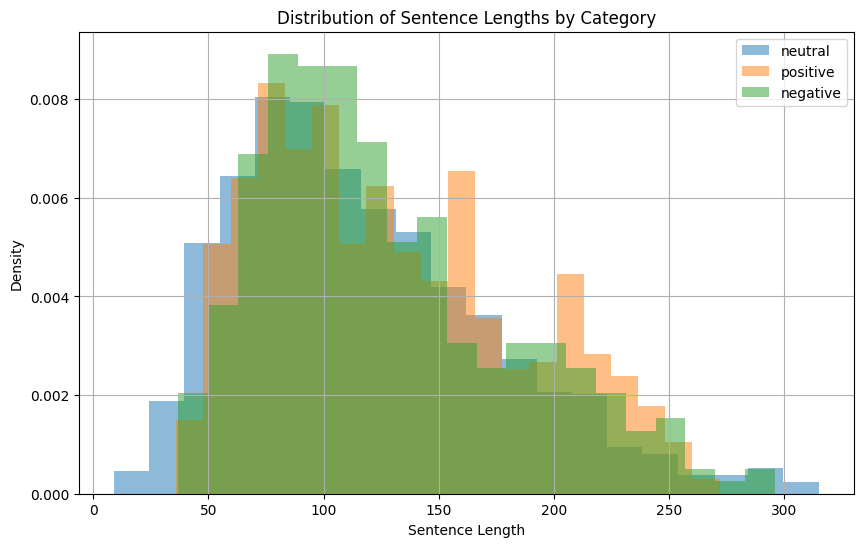

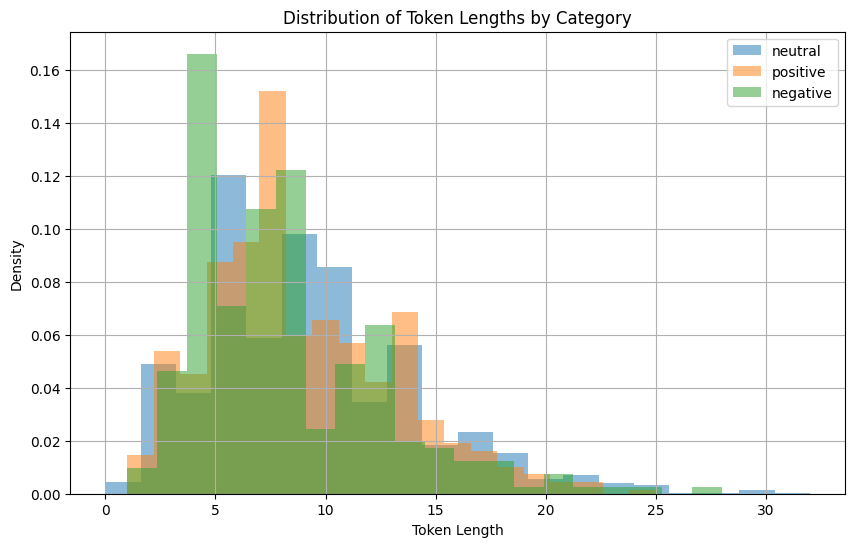

In [24]:
# Analyze the distribution of sentence lengths.

# Calculate token lenghts
df['sent_len'] = df['sentence'].apply(len)
df['token_len'] = df['lemma_tokens'].apply(len)

# Distribution prior to preprocessing
plt.figure(figsize=(10, 6))
for category in df['category'].unique():
    subset = df[df['category'] == category]
    plt.hist(subset['sent_len'], bins=20, alpha=0.5, label=category, density=True)

plt.title('Distribution of Sentence Lengths by Category')
plt.xlabel('Sentence Length')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

# Distribution after preprocessing
plt.figure(figsize=(10, 6))
for category in df['category'].unique():
    subset = df[df['category'] == category]
    plt.hist(subset['token_len'], bins=20, alpha=0.5, label=category, density=True)

plt.title('Distribution of Token Lengths by Category')
plt.xlabel('Token Length')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


- Sentence Length - most of the sentences range between 50-150 length
- Token length - most of the sentences range between 5-15 tokens

Evidently the token length went down drastically post text preprocessing using density parameter to normalize the histogram since the categorical data is imbalanced

## Named Entity Representation

Given the financial nature of the dataset, it's highly likely to contain various named entities relevant to the 
domain. Therefore, it's essential to perform Named Entity Recognition (NER) as part of the analysis. NER helps identify and categorize named entities such as organizations, currencies, and individuals within the text data. This process enhances the understanding of the underlying entities and their roles within the financial context, thus enriching the analysis and insights derived from the dataset.

In [25]:
# Using spacy for ease-of-use
def perform_ner(sentence):
    doc = nlp(sentence)
    ents = []
    for ent in doc.ents:
        ents.append((ent.text, ent.label_))
    
    return ents

In [26]:
# Apply NER to each sentence in the DataFrame
df['named_entities'] = df['sentence'].apply(perform_ner)

In [27]:
df.named_entities.head()

0                      [(Gran, PERSON), (Russia, GPE)]
1    [(the last quarter of 2010, DATE), (Componenta...
2    [(the third quarter of 2010, DATE), (5.2 %, PE...
3    [(EUR, ORG), (13.1, CARDINAL), (EUR, ORG), (8....
4    [(EUR 21.1, PRODUCT), (EUR, ORG), (18.6, CARDI...
Name: named_entities, dtype: object

In [28]:
# flattening entities for visualization
flattened_entities = []

# Flatten the list of tuples and append to the list
for index, row in df.iterrows():
    named_entities = row['named_entities']
    for entity, entity_type in named_entities:
        flattened_entities.append({'entity': entity, 'entity_type': entity_type})

# Convert the list of dictionaries to DataFrame
flattened_df = pd.DataFrame(flattened_entities)
flattened_df.head()

,entity,entity_type
0,Gran,PERSON
1,Russia,GPE
2,the last quarter of 2010,DATE
3,Componenta,ORG
4,EUR131,PERSON


In [29]:
flattened_df['entity_type'].unique()
flattened_df['entity_type'].value_counts()

entity_type
ORG            2188
DATE           1568
CARDINAL       1031
GPE             743
PERSON          516
PERCENT         363
NORP            302
MONEY           237
QUANTITY         75
PRODUCT          70
FAC              58
LOC              57
ORDINAL          35
TIME             32
LAW              20
WORK_OF_ART      12
EVENT             4
LANGUAGE          3
Name: count, dtype: int64

Text(0, 0.5, 'Count')

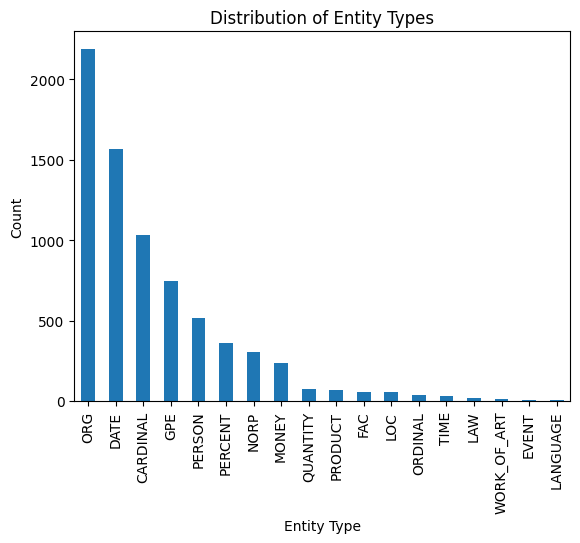

In [30]:
# Step 1: Classify entities based on their types
entity_counts = flattened_df['entity_type'].value_counts()

# Step 2: Visualize the distribution of entity types
entity_counts.plot(kind='bar', title='Distribution of Entity Types')
plt.xlabel('Entity Type')
plt.ylabel('Count')

In [31]:
# top entities appear to be ORG, DATE and CARDINAL in the data. Visualizing some of the entities

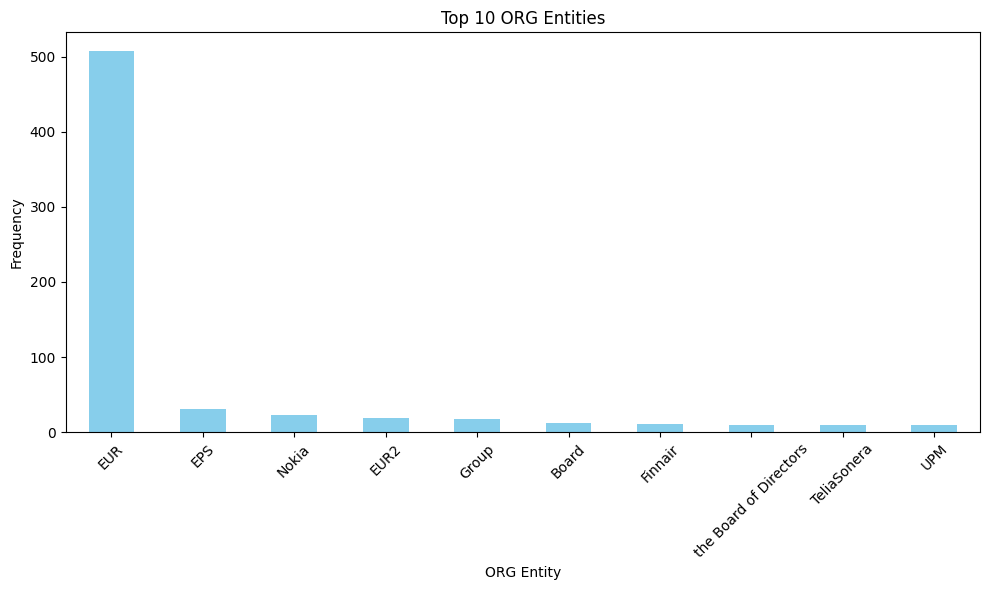

In [32]:
# Filter DataFrame to include only ORG entities
org_df = flattened_df[flattened_df['entity_type'] == 'ORG']

# Calculate frequency of each ORG entity
org_freq = org_df['entity'].value_counts()

# Select top 10 ORG entities
top_10_org = org_freq.head(10)

# Plot top 10 ORG entities
plt.figure(figsize=(10, 6))
top_10_org.plot(kind='bar', color='skyblue')
plt.title('Top 10 ORG Entities')
plt.xlabel('ORG Entity')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

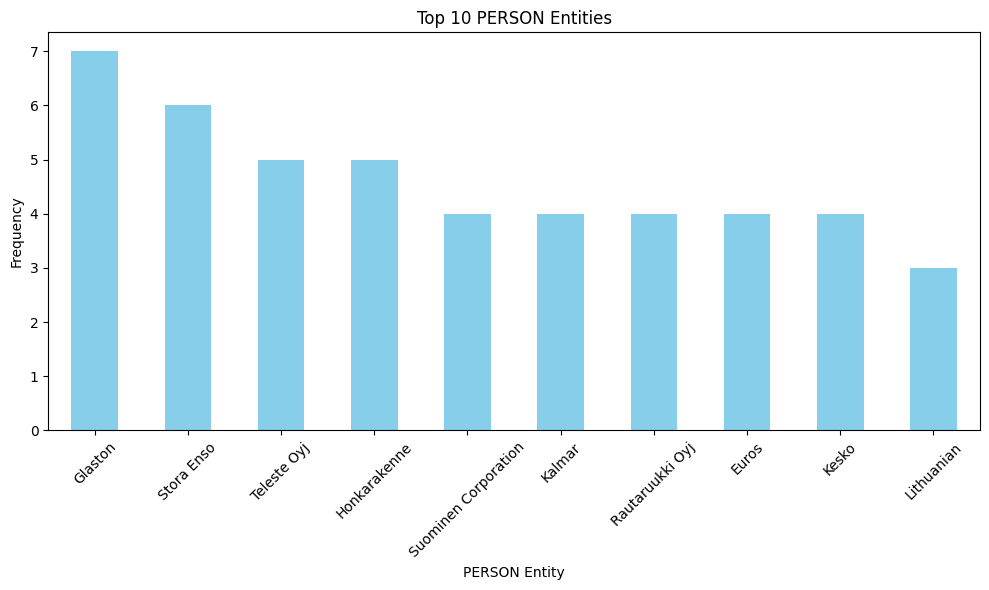

In [33]:
# Filter DataFrame to include only PERSON entities
person_df = flattened_df[flattened_df['entity_type'] == 'PERSON']

# Calculate frequency of each GPE entity
person_freq = person_df['entity'].value_counts()

# Select top 10 GPE entities
top_10_person = person_freq.head(10)

# Plot top 10 PERSON entities
plt.figure(figsize=(10, 6))
top_10_person.plot(kind='bar', color='skyblue')
plt.title('Top 10 PERSON Entities')
plt.xlabel('PERSON Entity')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

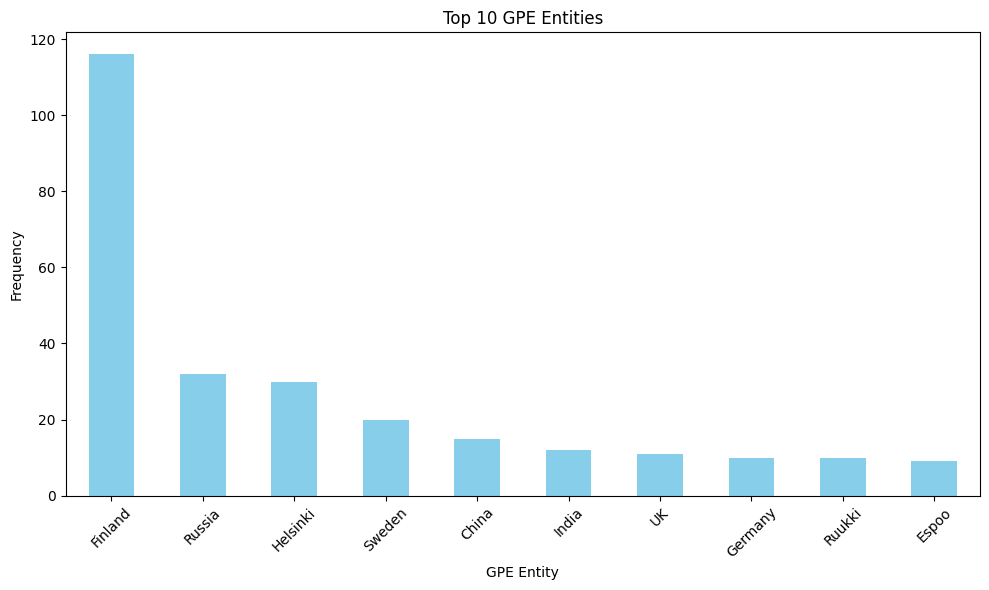

In [34]:
# Filter DataFrame to include only GPE entities
gpe_df = flattened_df[flattened_df['entity_type'] == 'GPE']

# Calculate frequency of each GPE entity
gpe_freq = gpe_df['entity'].value_counts()

# Select top 10 GPE entities
top_10_gpe = gpe_freq.head(10)

# Plot top 10 GPE entities
plt.figure(figsize=(10, 6))
top_10_gpe.plot(kind='bar', color='skyblue')
plt.title('Top 10 GPE Entities')
plt.xlabel('GPE Entity')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

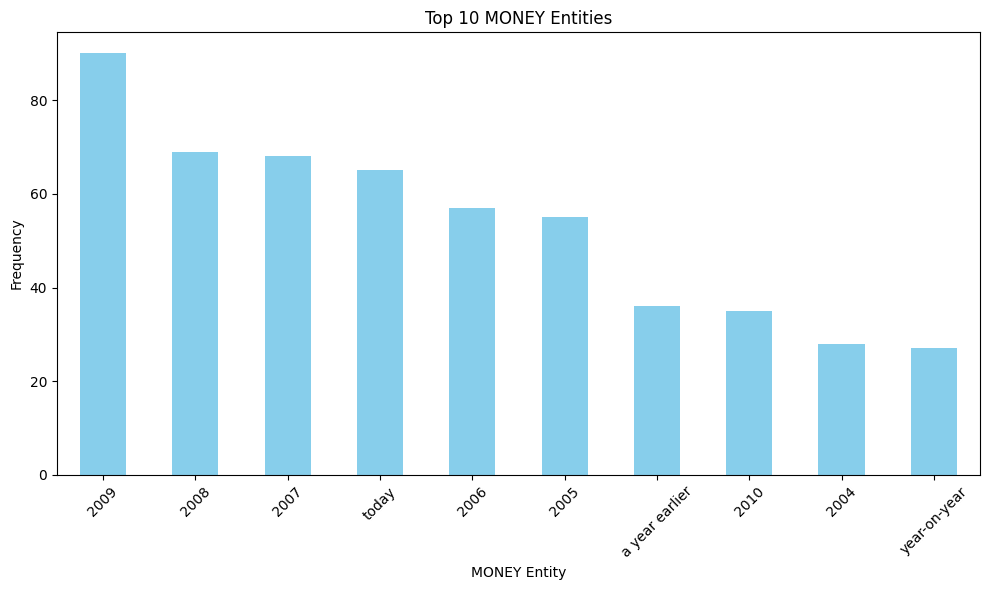

In [35]:
# Filter DataFrame to include only MONEY entities
money_df = flattened_df[flattened_df['entity_type'] == 'DATE']

# Calculate frequency of each MONEY entity
money_freq = money_df['entity'].value_counts()

# Select top 10 MONEY entities
top_10_money = money_freq.head(10)

# Plot top 10 MONEY entities
plt.figure(figsize=(10, 6))
top_10_money.plot(kind='bar', color='skyblue')
plt.title('Top 10 MONEY Entities')
plt.xlabel('MONEY Entity')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

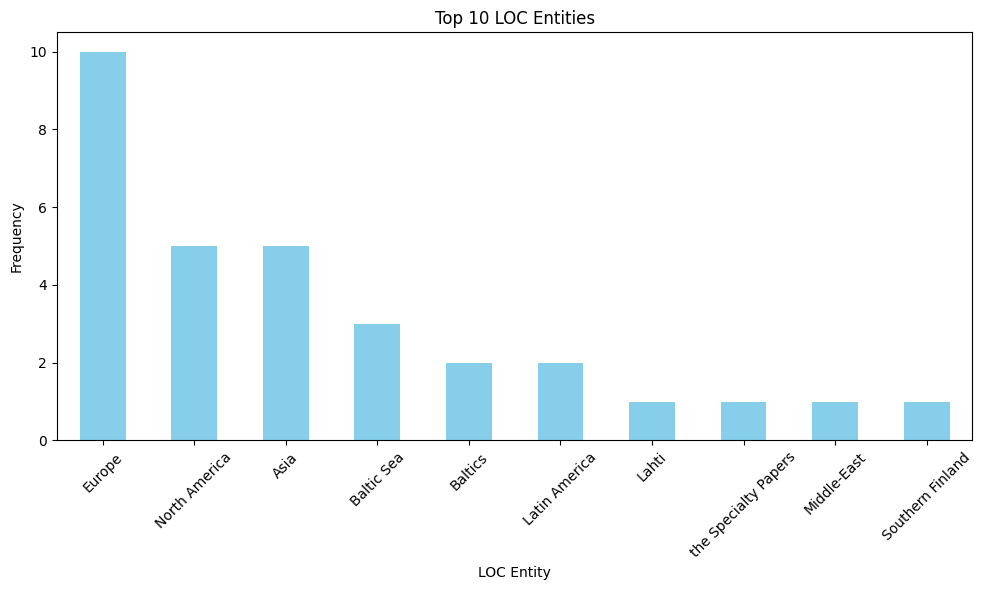

In [36]:
# Filter DataFrame to include only GPE entities
loc_df = flattened_df[flattened_df['entity_type'] == 'LOC']

# Calculate frequency of each GPE entity
loc_freq = loc_df['entity'].value_counts()

# Select top 10 GPE entities
top_10_loc = loc_freq.head(10)

# Plot top 10 GPE entities
plt.figure(figsize=(10, 6))
top_10_loc.plot(kind='bar', color='skyblue')
plt.title('Top 10 LOC Entities')
plt.xlabel('LOC Entity')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Concordance Analysis

Concordance analysis is a valuable technique in natural language processing (NLP) used to study the contexts in which specific words occur within a text corpus. It provides insights into how a particular word is used in different contexts and helps identify patterns of usage.

Concordance analysis typically involves searching for instances of a target word and displaying the surrounding 
text (usually a specified number of words or characters) to provide context. This technique is particularly 
useful for exploring the semantic associations, collocations, and usage patterns of important terms within a 
corpus.

In this notebook, concordance analysis is performed on the financial dataset to investigate the occurrences of key 
terms such as 'profit', 'loss', and 'fell'. By examining the contexts in which these terms appear, we aim to 
gain a deeper understanding of their usage patterns and semantic relationships within the financial text data.

In [37]:
# Combine all sentences into a single string
all_sentences = ' '.join(df['lemma_text'])
#all_sentences = ' '.join(df['sentence'])

# Tokenize the combined text
tokens = nltk.word_tokenize(all_sentences)

# Create a Text object for concordance and collocations
text = Text(tokens)

# Apply concordance on the Text object
concordance_profit = text.concordance('profit', width=100, lines=10)
concordance_loss = text.concordance('loss', width=100, lines=10)
concordance_loss = text.concordance('fell', width=100, lines=10)

Displaying 10 of 325 matches:
sale doubled period year earlier moved pre tax profit pre tax loss quarter net sale increased operat
 tax loss quarter net sale increased operating profit operating profit rose corresponding period rep
 net sale increased operating profit operating profit rose corresponding period representing net sal
ponding period representing net sale operating profit totalled representing net sale talentum report
epresenting net sale talentum report operating profit increased net sale totaled clothing retail cha
ing retail chain sepp sale increased operating profit rose net sale increased reach operating profit
profit rose net sale increased reach operating profit amounted compared loss prior year period found
corresponding period net sale increased pretax profit rose net sale surged teleste said sale came ac
e came acquisition made nordea group operating profit increased percent year year billion euro total
o total revenue percent billion euro operating profit month p

## Collocation Analysis

Collocation analysis is a technique used in natural language processing (NLP) to identify pairs or groups of 
words that frequently co-occur within a text corpus. These word combinations often carry significant meaning 
or convey specific linguistic patterns, making them valuable for understanding the underlying context and 
semantics of a text.

By performing collocation analysis on a financial dataset to uncover meaningful word associations
and linguistic patterns. By identifying frequent word pairs or phrases (bigrams and trigrams), the aim is to gain 
insights into the underlying structure and recurring patterns within the financial text data.

In [38]:
# Apply collocations on the Text object
bigram_measures = BigramAssocMeasures()
biagram_collocation = BigramCollocationFinder.from_words(tokens)
# Filter short words
filter_stops = lambda w: len(w) < 3
biagram_collocation.apply_word_filter(filter_stops)
# Calculate and display top bigram collocations
collocations_result = biagram_collocation.nbest(bigram_measures.likelihood_ratio, 15)
print("\nCollocations Biagram:")
collocations_result


Collocations Biagram:


[('operating', 'profit'),
 ('net', 'sale'),
 ('corresponding', 'period'),
 ('per', 'share'),
 ('year', 'earlier'),
 ('net', 'profit'),
 ('voting', 'right'),
 ('profit', 'rose'),
 ('non', 'recurring'),
 ('board', 'director'),
 ('earnings', 'per'),
 ('real', 'estate'),
 ('net', 'loss'),
 ('recurring', 'item'),
 ('cash', 'flow')]

In [39]:
# Apply collocations on the Text object for trigrams
trigram_collocation = TrigramCollocationFinder.from_words(tokens)
trigram_collocation.apply_word_filter(filter_stops)
trigram_collocation.apply_freq_filter(3)
# Calculate and display top trigram collocation
print("\nCollocations Trigram:")
trigram_collocation.nbest(TrigramAssocMeasures.likelihood_ratio, 15)


Collocations Trigram:


[('operating', 'profit', 'rose'),
 ('said', 'net', 'sale'),
 ('said', 'operating', 'profit'),
 ('period', 'operating', 'profit'),
 ('operating', 'profit', 'totalled'),
 ('operating', 'profit', 'totaled'),
 ('operating', 'profit', 'fell'),
 ('operating', 'profit', 'excluding'),
 ('operating', 'profit', 'decreased'),
 ('operating', 'profit', 'amounted'),
 ('operating', 'profit', 'quarter'),
 ('quarter', 'operating', 'profit'),
 ('totalled', 'operating', 'profit'),
 ('operating', 'profit', 'improved'),
 ('totaled', 'operating', 'profit')]

## Topic Modeling

Topic modeling is a statistical technique used to discover abstract topics within a collection of documents. It is particularly useful for exploring large text corpora and identifying latent themes or patterns that may not be immediately apparent through manual inspection.

In this notebook, we apply topic modeling, specifically Latent Dirichlet Allocation (LDA), to extract meaningful topics from a financial dataset. By identifying key topics within the data, we can gain valuable insights into the underlying themes and trends present in the text.

Topic 1:
company, order, group, business, investment, unit, said, financial, value, service

Topic 2:
profit, net, sale, share, year, operating, period, quarter, company, loss

Topic 3:
service, company, contract, said, market, product, solution, mobile, expected, total



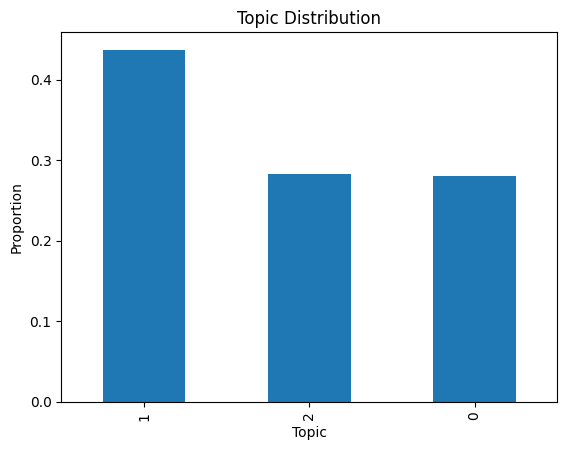

In [40]:
# Vectorization
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df['lemma_text'])

# Apply LDA
num_topics = 3
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

# Interpret Topics
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx + 1}:")
    print(", ".join([feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]))
    print()

# Assign Topics
topic_assignments = lda.transform(X)
# Add topic assignments to your DataFrame or use them for further analysis

# Example: Assigning topics to documents
df['topic'] = topic_assignments.argmax(axis=1)

# Example: Visualizing topic distribution
topic_distribution = df['topic'].value_counts(normalize=True)
topic_distribution.plot(kind='bar')
plt.title('Topic Distribution')
plt.xlabel('Topic')
plt.ylabel('Proportion')
plt.show()


- topic1 - topic seems to be related to general business structure and operations
- topic2 - focused on financial metrics, performance indicators
- topic3 - about market dynamics and products / services

The distribution plot shows the proportion of each topic in the dataset

# Text Embedding

In [41]:
# Split dataset into train and test dataset 
X_train_im, X_test, y_train_im, y_test = train_test_split(df['lemma_text'], df['label'], test_size=0.2, 
                                                          shuffle=True, stratify=df['label'], random_state=42)

In [42]:
def smote_oversampling(X, y):
    # Apply SMOTE oversampling only on the training dataset
    oversample = SMOTE(random_state=42)
    X_resampled, y_resampled = oversample.fit_resample(X, y)
    return X_resampled, y_resampled

## Bag of Words

In [43]:
# includes both unigrams and bigrams in the feature set.
cnt_vec = CountVectorizer(ngram_range=(1,2), max_features=30000)
X_train_bow = cnt_vec.fit_transform(X_train_im)
X_test_bow = cnt_vec.transform(X_test)

X_train_bow.shape
X_test_bow.shape

(453, 14480)

In [44]:
X_train_bow_resampled, y_train_bow_resampled = smote_oversampling(X_train_bow, y_train_im)
X_test_bow_resampled, y_test_bow_resampled = X_test_bow, y_test

In [45]:
y_train_bow_resampled.value_counts()

label
2    1113
1    1113
0    1113
Name: count, dtype: int64

In [46]:
y_test_bow_resampled.value_counts()

label
1    278
2    114
0     61
Name: count, dtype: int64

## TF-IDF

In [47]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_im)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [48]:
X_train_tfidf_resampled, y_train_tfidf_resampled = smote_oversampling(X_train_tfidf, y_train_im)
X_test_tfidf_resampled, y_test_tfidf_resampled = X_test_tfidf, y_test

In [49]:
y_train_tfidf_resampled.value_counts()

label
2    1113
1    1113
0    1113
Name: count, dtype: int64

# Modelling

In [50]:
# Evaluate the model based on accuracy, precision, recall, F1 and ROC score 
def evaluate_model(x_test, y_true, model, modelname): 
    y_pred = model.predict(x_test) 
    accuracy = accuracy_score(y_true, y_pred) 
    print('Accuracy: {:.2f}%'.format(accuracy)) 
    precision = precision_score(y_true, y_pred,average='weighted') 
    print('Precision: {:.2f}%'.format(precision)) 
    recall = recall_score(y_true, y_pred, average='weighted') 
    print('Recall: {:.2f}%'.format( recall)) 
    f1 = f1_score(y_true, y_pred,average='weighted') 
    print('Accuracy: {:.2f}%'.format(accuracy)) 
    # confusion matrix 
    matrix = confusion_matrix(y_true, y_pred) 
    print("Confusion matrix \n",matrix) 
    print('**********************************************************') 
    print('***************** Classification Report ****************') 
    print('**********************************************************') 
    print(classification_report(y_true,y_pred)) 

In [51]:
# Initialize models with default hyperparameters
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Naive Bayes": MultinomialNB()
}

# Hyperparameter grids for each model
param_grids = {
    "Logistic Regression": {"C": [0.1, 1, 10]},
    "Random Forest": {"n_estimators": [50, 100, 200], "max_depth": [None, 5, 10]},
    "SVM": {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]},
    "Gradient Boosting": {"n_estimators": [50, 100, 200], "max_depth": [3, 5, 10]},
    "Naive Bayes": {}
}

# Training and evaluation loop with hyperparameter tuning
def model_training(X_train, X_test, y_train, y_test, emb):
    # Training and evaluation loop with hyperparameter tuning
    for model_name, model in models.items():
        print(f"Training {model_name} with {emb} embeddings...")
        
        # Perform hyperparameter tuning using GridSearchCV
        if model_name in param_grids:
            grid_search = GridSearchCV(model, param_grids[model_name], cv=3, scoring="accuracy")
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
        else:
            best_model = model

        # Train the best model
        best_model.fit(X_train, y_train)

        # Evaluate the model
        print(f"Evaluating {model_name}...")
        evaluate_model(X_test, y_test, best_model, model_name)

# Training

## BOW data model training

In [52]:
model_training(X_train_bow_resampled, X_test_bow_resampled, y_train_bow_resampled, y_test_bow_resampled, 'BOW')

Training Logistic Regression with BOW embeddings...
Evaluating Logistic Regression...
Accuracy: 0.80%
Precision: 0.81%
Recall: 0.80%
Accuracy: 0.80%
Confusion matrix 
 [[ 42   4  15]
 [ 23 239  16]
 [ 13  21  80]]
**********************************************************
***************** Classification Report ****************
**********************************************************
              precision    recall  f1-score   support

           0       0.54      0.69      0.60        61
           1       0.91      0.86      0.88       278
           2       0.72      0.70      0.71       114

    accuracy                           0.80       453
   macro avg       0.72      0.75      0.73       453
weighted avg       0.81      0.80      0.80       453

Training Random Forest with BOW embeddings...
Evaluating Random Forest...
Accuracy: 0.77%
Precision: 0.78%
Recall: 0.77%
Accuracy: 0.77%
Confusion matrix 
 [[ 39   5  17]
 [ 23 237  18]
 [ 19  24  71]]
****************************

## TD-IDF data model training

In [53]:
model_training(X_train_tfidf_resampled, X_test_tfidf, y_train_tfidf_resampled, y_test, 'TF-IDF')

Training Logistic Regression with TF-IDF embeddings...
Evaluating Logistic Regression...
Accuracy: 0.87%
Precision: 0.87%
Recall: 0.87%
Accuracy: 0.87%
Confusion matrix 
 [[ 43   6  12]
 [  6 265   7]
 [ 14  15  85]]
**********************************************************
***************** Classification Report ****************
**********************************************************
              precision    recall  f1-score   support

           0       0.68      0.70      0.69        61
           1       0.93      0.95      0.94       278
           2       0.82      0.75      0.78       114

    accuracy                           0.87       453
   macro avg       0.81      0.80      0.80       453
weighted avg       0.87      0.87      0.87       453

Training Random Forest with TF-IDF embeddings...
Evaluating Random Forest...
Accuracy: 0.85%
Precision: 0.85%
Recall: 0.85%
Accuracy: 0.85%
Confusion matrix 
 [[ 40   4  17]
 [  2 266  10]
 [ 10  24  80]]
**********************

TF-IDF tokenization generally improved the accuracy of most algorithms compared to bag of words representation. This suggests that TF-IDF effectively captures the importance of terms in the documents, leading to improved classification performance.
- Logistic Regression, Gradient Descent, and Random Forest performed reasonably well with both BOW and TF-IDF tokenization, achieving accuracy rates ranging from 77% to 87%.
- Naive Bayes also achieved good accuracy with BOW, but its performance remained consistent with TF-IDF tokenization.
- Support Vector Machine (SVM) showed the most significant improvement in accuracy when using TF-IDF, suggesting that term weighting is crucial for SVM classification.


## LSTM

LSTMs are a specialized type of Recurrent Neural Networks. The model is trained over 10 epochs using the Adam optimizer. During training, the loss function used is categorical cross-entropy, and the metric used to monitor performance is accuracy.

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the maximum number of words to consider as features
# Define the maximum length of input sequences
# Define the embedding dimension
MAX_WORDS = 10000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100


# Tokenize the text data
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(X_train_im)

# Convert text data to sequences
sequences_train = tokenizer.texts_to_sequences(X_train_im)
sequences_test = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
X_train_pad = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
X_test_pad = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)

# Define the LSTM model
model = Sequential()
model.add(Embedding(MAX_WORDS, EMBEDDING_DIM))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(256, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
print(model.summary())

# Train the model
history = model.fit(X_train_pad, y_train_im, epochs=20, batch_size=128, validation_split=0.2)

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 868ms/step - accuracy: 0.5191 - loss: 1.0442 - val_accuracy: 0.6088 - val_loss: 0.9371
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 777ms/step - accuracy: 0.6103 - loss: 0.9308 - val_accuracy: 0.6088 - val_loss: 0.9220
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 777ms/step - accuracy: 0.6275 - loss: 0.9035 - val_accuracy: 0.6088 - val_loss: 0.8842
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 783ms/step - accuracy: 0.6405 - loss: 0.8486 - val_accuracy: 0.6777 - val_loss: 0.7586
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 820ms/step - accuracy: 0.7127 - loss: 0.7065 - val_accuracy: 0.7713 - val_loss: 0.6182
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 832ms/step - accuracy: 0.7567 - loss: 0.5798 - val_accuracy: 0.7576 - val_loss: 0.5993
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 772ms/step - accuracy: 0.7944 - loss: 0.4840 - val_accuracy: 0.7631 - val_loss: 0.6256
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 785ms/step - accuracy: 0.7951 - loss: 0.4419 - val_a

In [55]:
def predict_model(predict_statement):
    sequences_predict = tokenizer.texts_to_sequences([predict_statement])
    X_predict_pad = pad_sequences(sequences_predict, maxlen=MAX_SEQUENCE_LENGTH)
    predictions = model.predict(X_predict_pad)
    predicted_class = np.argmax(predictions, axis=1)
    if predicted_class == [2]:
        predicted_output = 'positive'
    elif predicted_class == [0]:
        predicted_output = 'negative'
    elif predicted_class == [1]:
        predicted_output = 'neutral'
    else:
        predicted_output = predicted_class
        
    return (print("Predicted class:", predicted_class, predicted_output))

In [56]:
# positive
predict_model("Pharmaceuticals group Orion Corp reported a rise in its third-quarter earnings \
        that were not hit by larger expenditures on R&D and marketing")
# negative
predict_model("Pharmaceuticals group Orion Corp reported a fall in its third-quarter earnings \
        that were hit by larger expenditures on R&D and marketing")
# neutral
predict_model("Judge orders Organization to pay $364M in long-awaited civil fraud ruling")
# neutral / negative
predict_model("Werfel defends IRS against Republican efforts to slash funding")
# negative
predict_model("Krispy Kreme faces double-digit inflation in some costs: CFO")
# positive
predict_model("Lyft shares rise 35% after earnings report typo sparks confusion")
# negative
predict_model("Lyft stock sunk 35% after earnings report typo sparks confusion")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
Predicted class: [0] negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Predicted class: [0] negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Predicted class: [1] neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Predicted class: [1] neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Predicted class: [1] neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted class: [2] positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted class: [2] positive
